<font size="+3">           Data Science - Assignment 2</font>

<font size="+1">           Libraries</font>

In [35]:
import warnings
import os
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

<font size="+1">Loading the dataset</font>

In [36]:
#folder containing the CSV files.
folder_path = r'C:\Users\nikhi\OneDrive\Desktop\College Docs\Data Science\Assignment\weatherdata_for_students'


In [37]:
#CSV files in the folder starting with 'brighton' and 'colchester'.
file_list1 = [file for file in os.listdir(folder_path) if file.startswith('brighton') and file.endswith('.csv')]
file_list2 = [file for file in os.listdir(folder_path) if file.startswith('colchester') and file.endswith('.csv')]

In [38]:
#df of Brighton.
dfs_1 = []
#read CSV file and append to df.
for file in file_list1:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs_1.append(df[1:])
combined_df1 = pd.concat(dfs_1, ignore_index=True)
combined_df1 = combined_df1.iloc[:,:16]

In [39]:
#df of Colchester.
dfs_2 = []
#read CSV file and append to df.
for file in file_list2:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs_2.append(df[1:])
combined_df2 = pd.concat(dfs_2, ignore_index=True)
combined_df2 = combined_df2.iloc[:,:16]

In [40]:
#Linearly interpolating the data to fill in all the null values. 
combined_df1 = combined_df1.interpolate(method='linear', axis=0)
combined_df2 = combined_df2.interpolate(method='linear', axis=0)

In [41]:
#Mapping preciptype.
encoder = LabelEncoder()
combined_df1['preciptype'].fillna(0, inplace=True)
mapping = {'rain': 1, 'rain,snow': 2}
combined_df1['preciptype'] = combined_df1['preciptype'].map(mapping)
combined_df1['preciptype'].fillna(0, inplace=True)

In [42]:
#Replacing NaN values with 0.
combined_df2['preciptype'].fillna(0, inplace=True)
# Mapping values to integers.
mapping = {'rain': 1, 'rain,snow': 2}
combined_df2['preciptype'] = combined_df2['preciptype'].map(mapping)
# Filling remaining NaN values with 0.
combined_df2['preciptype'].fillna(0, inplace=True)

<font size="+1">Data Preprocessing</font>

In [43]:
#This is for Brighton data.

combined_df1['datetime'] = pd.to_datetime(combined_df1['datetime'])


#Calculating average for the following columns. 
avg_columns = ['temp', 'dew', 'humidity', 'snowdepth', 'sealevelpressure', 'cloudcover', 'uvindex']
data_avg1 = combined_df1.groupby(combined_df1['datetime'].dt.date)[avg_columns].mean().reset_index()

#Finding maximum for 'precipprob' and 'preciptype'.
avg_columns = ['temp', 'dew', 'humidity', 'snowdepth', 'sealevelpressure', 'cloudcover', 'uvindex']
data_avg1 = combined_df1.groupby(combined_df1['datetime'].dt.date)[avg_columns].mean().reset_index()

# Calculating average for 'solarradiation' and 'solarenergy' for values greater than thresholds.
threshold_solarradiation = 150
threshold_solarenergy = 0.6
avg_solarradiation = combined_df1[combined_df1['solarradiation'] > threshold_solarradiation].groupby(combined_df1['datetime'].dt.date)['solarradiation'].mean().reset_index()
avg_solarenergy = combined_df1[combined_df1['solarenergy'] > threshold_solarenergy].groupby(combined_df1['datetime'].dt.date)['solarenergy'].mean().reset_index()

#Calculating average of cells per day in range 0-180 for 'winddir'.
#Filtering winddir values within range 0-180.
avg_winddir = combined_df1[(combined_df1['winddir'] >= 0) & (combined_df1['winddir'] <= 180)].groupby(combined_df1['datetime'].dt.date)['winddir'].mean().reset_index()
#Filtering wind speed based on conditions.
threshold_windspeed = 21
# ^ This is the Threshold for wind speed.
sum_windspeed = combined_df1[(combined_df1['windspeed'] > threshold_windspeed) & (combined_df1['winddir'] >= 0) & (combined_df1['winddir'] <= 180)].groupby(combined_df1['datetime'].dt.date)['windspeed'].mean().reset_index()

#Calculating number of hours exceeding thresholds.

#For solar radiation
no_hrs_greatersolar = combined_df1.groupby(combined_df1['datetime'].dt.date)['solarradiation'].apply(lambda x: (x > threshold_solarradiation).sum()).reset_index()
no_hrs_greatersolar.columns = ['datetime', 'no_hrs_greatersolar']

#For wind speed
no_hrs_greaterwind = combined_df1.groupby(combined_df1['datetime'].dt.date)['windspeed'].apply(lambda x: (x > threshold_windspeed).sum()).reset_index()
no_hrs_greaterwind.columns = ['datetime', 'no_hrs_greaterwind']


#Merging all DataFrames into a single DataFrame named data1.
data1 = pd.merge(avg_solarradiation, avg_solarenergy, on='datetime', how='outer')
data1 = pd.merge(data1, avg_winddir, on='datetime', how='outer')
data1 = pd.merge(data1, sum_windspeed, on='datetime', how='outer')
data1 = pd.merge(data1 , data_avg1, on = 'datetime', how='outer')
data1 = pd.merge(data1 , data_max1, on = 'datetime', how='outer')
data1 = pd.merge(data1, no_hrs_greatersolar, on='datetime', how='outer')
data1 = pd.merge(data1, no_hrs_greaterwind, on='datetime', how='outer')

#Target Values. 
y_values = ((data1['no_hrs_greaterwind'] >= 11) | (data1['no_hrs_greatersolar'] >= 5)).astype(int)
y_df = pd.DataFrame({'y': y_values})

data1 = pd.merge(data1, y_df, left_index=True, right_index=True)
data1 = data1.fillna(0)

#Displaying the results.
print(data1.info())

#Saving 
#data1.to_csv(r'C:\Users\nikhi\OneDrive\Desktop\College Docs\Data Science\Assignment 2 WORK')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             2000 non-null   object 
 1   solarradiation       2000 non-null   float64
 2   solarenergy          2000 non-null   float64
 3   winddir              2000 non-null   float64
 4   windspeed            2000 non-null   float64
 5   temp                 2000 non-null   float64
 6   dew                  2000 non-null   float64
 7   humidity             2000 non-null   float64
 8   snowdepth            2000 non-null   float64
 9   sealevelpressure     2000 non-null   float64
 10  cloudcover           2000 non-null   float64
 11  uvindex              2000 non-null   float64
 12  precipprob           2000 non-null   float64
 13  preciptype           2000 non-null   float64
 14  no_hrs_greatersolar  2000 non-null   int64  
 15  no_hrs_greaterwind   2000 non-null   i

In [44]:
data1.head()

,datetime,solarradiation,solarenergy,winddir,windspeed,temp,dew,humidity,snowdepth,sealevelpressure,cloudcover,uvindex,precipprob,preciptype,no_hrs_greatersolar,no_hrs_greaterwind,y
0,2010-01-01,172.933333,0.700000,10.166667,21.8,0.547826,-2.152174,82.424348,0.000000,1005.265217,28.486957,0.391304,100.0,2.0,3,1,0
1,2010-01-02,228.350000,0.825000,0.000000,0.0,0.570833,-1.454167,86.658750,0.000000,1016.112500,34.954167,0.458333,100.0,2.0,4,0,0
2,2010-01-03,200.000000,0.766667,36.400000,0.0,0.075000,-1.629167,88.680833,0.000000,1022.125000,36.162500,0.416667,100.0,2.0,4,0,0
3,2010-01-04,201.400000,0.766667,4.500000,0.0,-2.095833,-3.620833,89.622917,0.000000,1019.277083,39.191667,0.416667,100.0,2.0,4,0,0
4,2010-01-05,152.400000,0.000000,118.571429,0.0,-1.095833,-2.704167,89.187917,1.666667,1005.508333,58.770833,0.333333,100.0,2.0,2,2,0


In [45]:
#combined_df1.to_csv(r'C:\Users\nikhi\OneDrive\Desktop\College Docs\Data Science\New folder\Assignment 2 WORK\cdf1.csv')
#My reference

In [46]:
#This is for Colchester data.

combined_df2['datetime'] = pd.to_datetime(combined_df2['datetime'])
#Calculating average for selected columns
avg_columns = ['temp', 'dew', 'humidity', 'snowdepth', 'sealevelpressure', 'cloudcover', 'uvindex']
data_avg2 = combined_df2.groupby(combined_df2['datetime'].dt.date)[avg_columns].mean().reset_index()
#Finding maximum for 'precipprob' and 'preciptype'
max_precip_columns = ['precipprob', 'preciptype']
data_max2 = combined_df2.groupby(combined_df2['datetime'].dt.date)[max_precip_columns].max().reset_index()
#Calculating average for 'solarradiation' and 'solarenergy' for values greater than thresholds
threshold_solarradiation = 150
threshold_solarenergy = 0.6
avg_solarradiation = combined_df2[combined_df2['solarradiation'] > threshold_solarradiation].groupby(combined_df2['datetime'].dt.date)['solarradiation'].mean().reset_index()
avg_solarenergy = combined_df2[combined_df2['solarenergy'] > threshold_solarenergy].groupby(combined_df2['datetime'].dt.date)['solarenergy'].mean().reset_index()
#Calculating average of cells per day in range 90-270 for 'winddir' column
# Filter winddir values within range 90-270
avg_winddir = combined_df2[(combined_df2['winddir'] >= 90) & (combined_df2['winddir'] <= 270)].groupby(combined_df2['datetime'].dt.date)['winddir'].mean().reset_index()
#Filtering wind speed based on conditions
threshold_windspeed = 21  # Threshold for wind speed
sum_windspeed = combined_df2[(combined_df1['windspeed'] > threshold_windspeed) & (combined_df2['winddir'] >= 0) & (combined_df2['winddir'] <= 180)].groupby(combined_df1['datetime'].dt.date)['windspeed'].mean().reset_index()
#Calculating number of hours exceeding threshold
#For solar radiation
no_hrs_greatersolar = combined_df2.groupby(combined_df2['datetime'].dt.date)['solarradiation'].apply(lambda x: (x > threshold_solarradiation).sum()).reset_index()
no_hrs_greatersolar.columns = ['datetime', 'no_hrs_greatersolar']
# For wind speed
no_hrs_greaterwind = combined_df2.groupby(combined_df2['datetime'].dt.date)['windspeed'].apply(lambda x: (x > threshold_windspeed).sum()).reset_index()
no_hrs_greaterwind.columns = ['datetime', 'no_hrs_greaterwind']



# Merge all DataFrames into a single DataFrame named data1
data2 = pd.merge(avg_solarradiation, avg_solarenergy, on='datetime', how='outer')
data2 = pd.merge(data2, avg_winddir, on='datetime', how='outer')
data2 = pd.merge(data2, sum_windspeed, on='datetime', how='outer')
data2 = pd.merge(data2 , data_avg2, on = 'datetime', how='outer')
data2 = pd.merge(data2 , data_max2, on = 'datetime', how='outer')
data2 = pd.merge(data2, no_hrs_greatersolar, on='datetime', how='outer')
data2 = pd.merge(data2, no_hrs_greaterwind, on='datetime', how='outer')

#Target Values.
y_values = ((data2['no_hrs_greaterwind'] >= 11) | (data2['no_hrs_greatersolar'] >= 5)).astype(int)
y_df = pd.DataFrame({'y': y_values})

data2 = pd.merge(data2, y_df, left_index=True, right_index=True)
data2 = data2.fillna(0)

# Display the results
print(data2.head())
data2.to_csv(r'D:\dtat2.csv')


     datetime  solarradiation  solarenergy     winddir  windspeed      temp  \
0  2000-01-01             0.0          0.0  220.153846        0.0  7.291304   
1  2000-01-02             0.0          0.0  207.652174        0.0  7.154167   
2  2000-01-03             0.0          0.0  217.166667        0.0  8.604167   
3  2000-01-04             0.0          0.0  204.285714        0.0  4.195833   
4  2000-01-05             0.0          0.0  194.070833        0.0  5.475000   

        dew   humidity  snowdepth  sealevelpressure  cloudcover  uvindex  \
0  6.265217  93.340870        0.0       1024.169565   80.434783      0.0   
1  5.570833  89.950417        0.0       1024.929167   90.000000      0.0   
2  7.183333  90.907917        0.0       1017.916667  100.000000      0.0   
3  3.033333  92.427500        0.0       1013.983333   61.125000      0.0   
4  3.500000  87.269167        0.0       1014.366667   73.250000      0.0   

   precipprob  preciptype  no_hrs_greatersolar  no_hrs_greaterwind  

In [47]:
data_b = data1.copy()
data_c = data2.copy()

<font size="+1">           BaseLine 1 and BaseLine2 Visualisation</font>

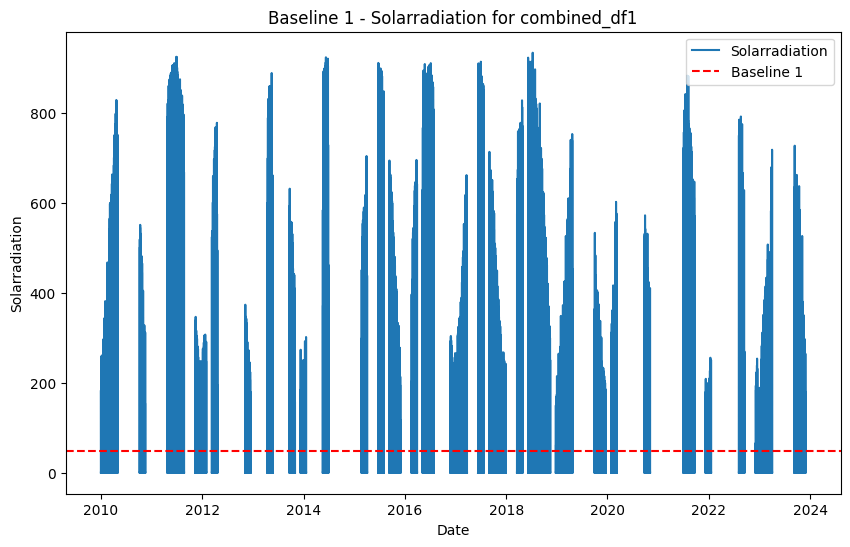

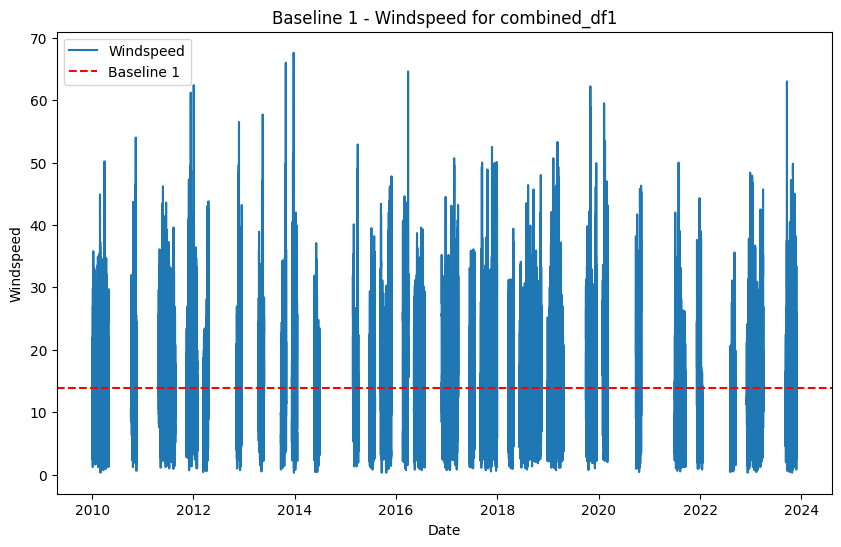

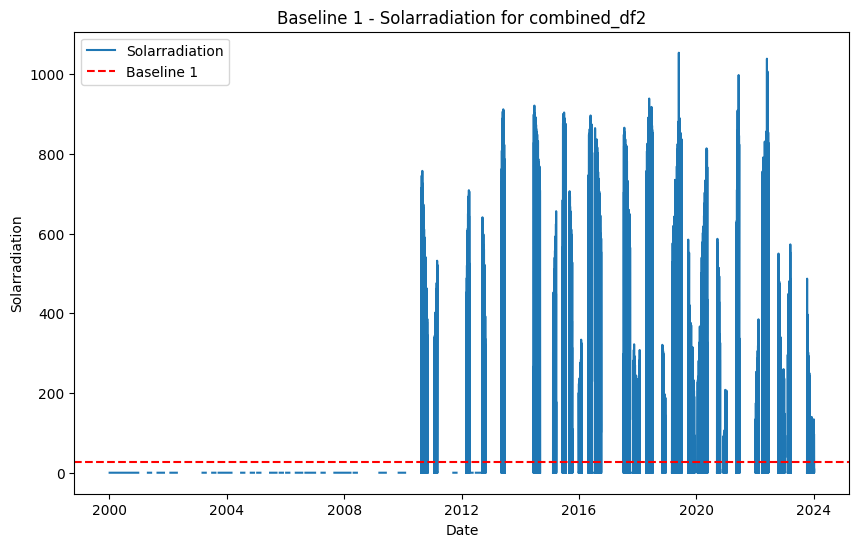

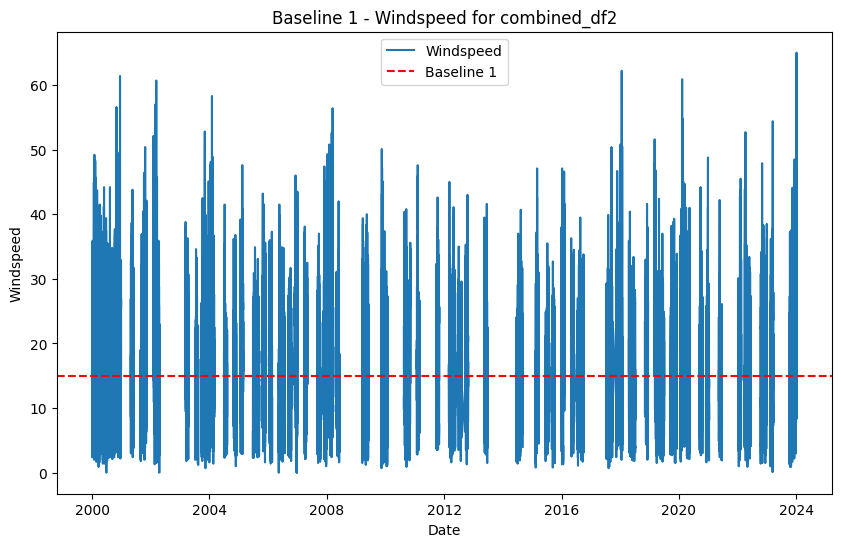

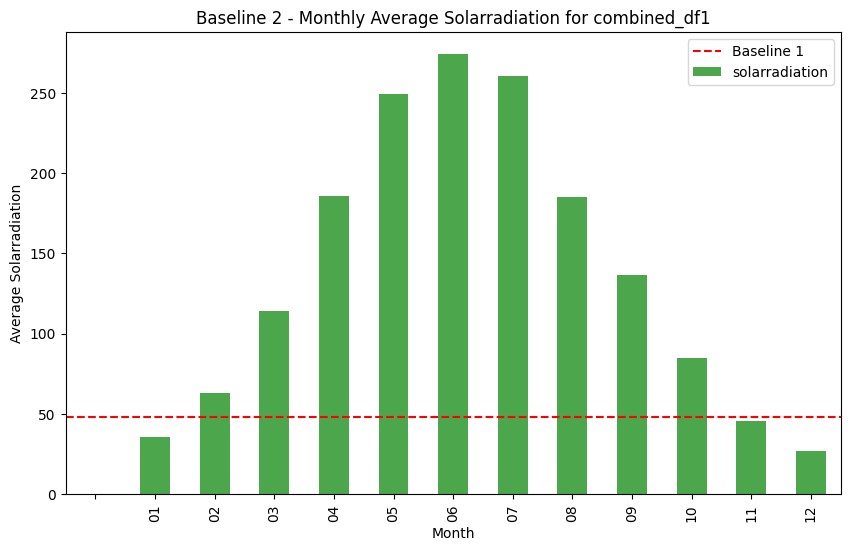

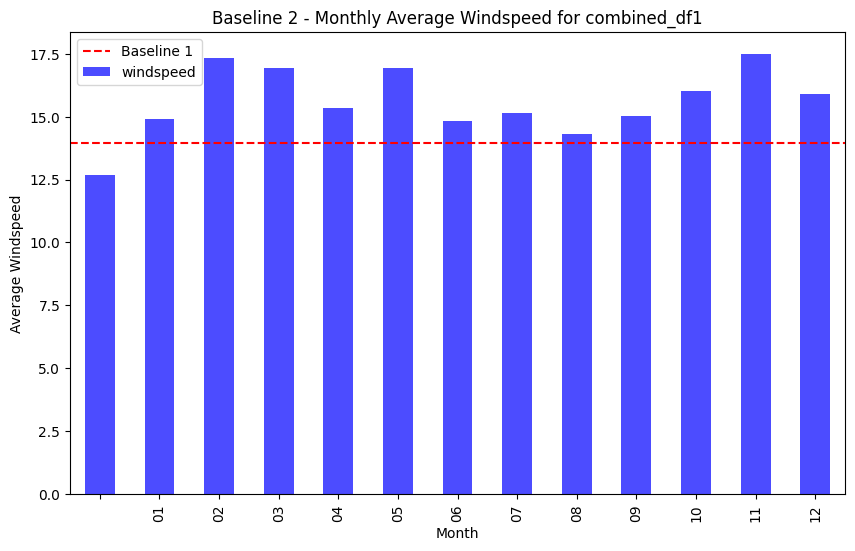

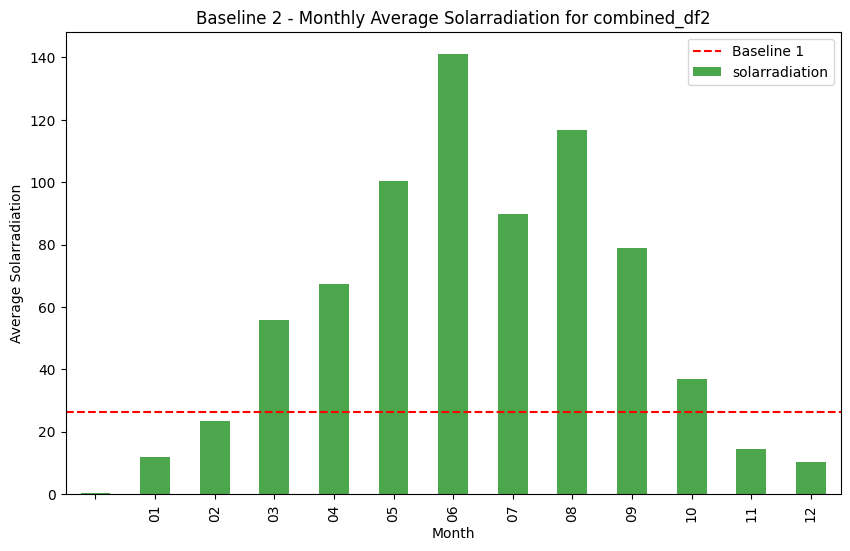

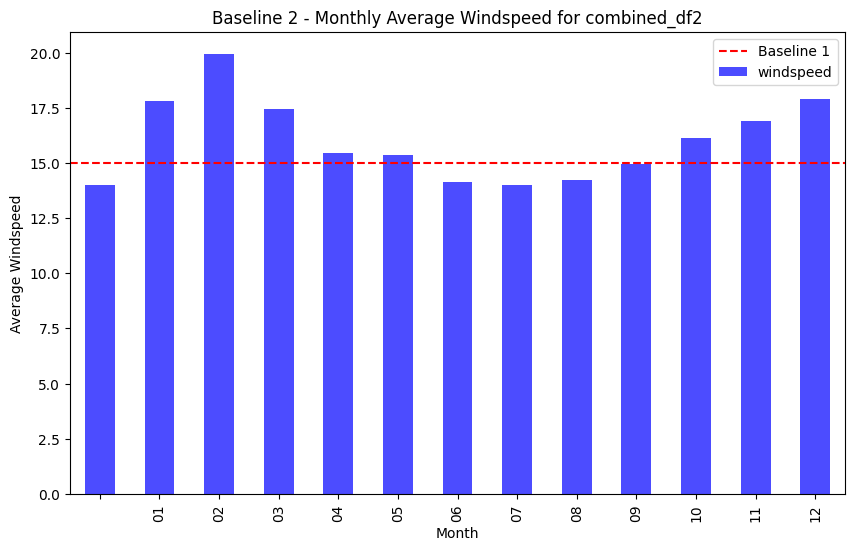

In [48]:
#Loading data into combined_df1 and combined_df2

#Convert 'datetime' column to datetime format
combined_df1['datetime'] = pd.to_datetime(combined_df1['datetime'])
combined_df2['datetime'] = pd.to_datetime(combined_df2['datetime'])
#Convert datetime column to string and extract month
combined_df1['month'] = combined_df1['datetime'].astype(str).str[5:7]
combined_df2['month'] = combined_df2['datetime'].astype(str).str[5:7]
#Calculating Baselines.
baseline1_solarradiation1 = combined_df1['solarradiation'].mean()
baseline1_windspeed1 = combined_df1['windspeed'].mean()
baseline1_solarradiation2 = combined_df2['solarradiation'].mean()
baseline1_windspeed2 = combined_df2['windspeed'].mean()
#Calculating monthly averages for Baseline 2.
baseline2_solarradiation1 = combined_df1.groupby('month')['solarradiation'].mean()
baseline2_windspeed1= combined_df1.groupby('month')['windspeed'].mean()
baseline2_solarradiation2 = combined_df2.groupby('month')['solarradiation'].mean()
baseline2_windspeed2 = combined_df2.groupby('month')['windspeed'].mean()

#Plotting Baseline 1 - Solarradiation for combined_df1
plt.figure(figsize=(10, 6))
plt.plot(combined_df1['datetime'], combined_df1['solarradiation'], label='Solarradiation')
plt.axhline(y=baseline1_solarradiation1, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Date')
plt.ylabel('Solarradiation')
plt.title('Baseline 1 - Solarradiation for combined_df1')
plt.legend()
plt.show()

#Plotting Baseline 1 - Windspeed for combined_df1
plt.figure(figsize=(10, 6))
plt.plot(combined_df1['datetime'], combined_df1['windspeed'], label='Windspeed')
plt.axhline(y=baseline1_windspeed1, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Date')
plt.ylabel('Windspeed')
plt.title('Baseline 1 - Windspeed for combined_df1')
plt.legend()
plt.show()

#Plotting Baseline 1 - Solarradiation for combined_df2
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['datetime'], combined_df2['solarradiation'], label='Solarradiation')
plt.axhline(y=baseline1_solarradiation2, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Date')
plt.ylabel('Solarradiation')
plt.title('Baseline 1 - Solarradiation for combined_df2')
plt.legend()
plt.show()

#Plotting Baseline 1 - Windspeed for combined_df2
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['datetime'], combined_df2['windspeed'], label='Windspeed')
plt.axhline(y=baseline1_windspeed2, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Date')
plt.ylabel('Windspeed')
plt.title('Baseline 1 - Windspeed for combined_df2')
plt.legend()
plt.show()

#Plotting Baseline 2 - Solarradiation for combined_df1
plt.figure(figsize=(10, 6))
baseline2_solarradiation1.plot(kind='bar', color='green', alpha=0.7)
plt.axhline(y=baseline1_solarradiation1, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Month')
plt.ylabel('Average Solarradiation')
plt.title('Baseline 2 - Monthly Average Solarradiation for combined_df1')
plt.legend()
plt.show()

#Plotting Baseline 2 - Windspeed for combined_df1
plt.figure(figsize=(10, 6))
baseline2_windspeed1.plot(kind='bar', color='blue', alpha=0.7)
plt.axhline(y=baseline1_windspeed1, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Month')
plt.ylabel('Average Windspeed')
plt.title('Baseline 2 - Monthly Average Windspeed for combined_df1')
plt.legend()
plt.show()

#Plotting Baseline 2 - Solarradiation for combined_df2
plt.figure(figsize=(10, 6))
baseline2_solarradiation2.plot(kind='bar', color='green', alpha=0.7)
plt.axhline(y=baseline1_solarradiation2, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Month')
plt.ylabel('Average Solarradiation')
plt.title('Baseline 2 - Monthly Average Solarradiation for combined_df2')
plt.legend()
plt.show()

#Plotting Baseline 2 - Windspeed for combined_df2
plt.figure(figsize=(10, 6))
baseline2_windspeed2.plot(kind='bar', color='blue', alpha=0.7)
plt.axhline(y=baseline1_windspeed2, color='r', linestyle='--', label='Baseline 1')
plt.xlabel('Month')
plt.ylabel('Average Windspeed')
plt.title('Baseline 2 - Monthly Average Windspeed for combined_df2')
plt.legend()
plt.show()

<font size="+1">Machine Learning Model</font>

In [49]:
#LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n.squeeze(0))
        out = self.sigmoid(out)
        return out

#Brighton. 

data_b.drop(columns=['datetime'], inplace=True)
#Shifting y by one day to predict the next day's weather.
data_b['y_shifted'] = data_b['y'].shift(-1)

#Dropping rows with NaN values resulting from the shift
data_b.dropna(inplace=True)

#Removing the last row from X and y
X1 = data_b.drop(columns=['y_shifted']).values[:-1]
y1 = data_b['y_shifted'].values[:-1]

#Normalising the features using MinMaxScaler.
scaler = MinMaxScaler()
X1_scaled = scaler.fit_transform(X1)

#Reshaping the features into 3D array (samples, time steps, features).
X1_reshaped = X1_scaled.reshape(X1_scaled.shape[0], 1, X1_scaled.shape[1])

#Splitting the data into train, test, and validation sets (70/20/10 split).
X1_train, X1_temp, y1_train, y1_temp = train_test_split(X1_reshaped, y1, test_size=0.3, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.33, random_state=42)

#Converting data to PyTorch tensors.
X1_train = torch.Tensor(X1_train)
y1_train = torch.Tensor(y1_train).view(-1, 1)
X1_val = torch.Tensor(X1_val)
y1_val = torch.Tensor(y1_val).view(-1, 1)
X1_test = torch.Tensor(X1_test)
y1_test = torch.Tensor(y1_test).view(-1, 1)

#Defining hyperparameters
input_size = X1_train.shape[2]
hidden_size = 100
output_size = 1
num_epochs = 100
learning_rate = 0.001

#Initializing the model.
model1 = LSTMModel(input_size, hidden_size, output_size)

#Defining loss function and optimizer.
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

#Training the model.
for epoch in range(num_epochs):
    model1.train()
    optimizer.zero_grad()
    outputs = model1(X1_train)
    loss = criterion(outputs, y1_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

#Evaluating the model on the validation set.
model1.eval()
with torch.no_grad():
    outputs = model1(X1_val)
    val_loss1 = criterion(outputs, y1_val)
    predicted = outputs.round()
    val_accuracy1 = accuracy_score(y1_val.numpy(), predicted.numpy())

print(f'Validation Loss: {val_loss1.item():.4f}, Validation Accuracy: {val_accuracy1*100:.4f}')

#Evaluating the model on the test set.
with torch.no_grad():
    outputs = model1(X1_test)
    test_loss1 = criterion(outputs, y1_test)
    predicted = outputs.round()
    test_accuracy1 = accuracy_score(y1_test.numpy(), predicted.numpy())

print(f'Test Loss: {test_loss1.item():.4f}, Test Accuracy: {test_accuracy1*100:.4f}')




Epoch [10/100], Loss: 0.6375
Epoch [20/100], Loss: 0.5912
Epoch [30/100], Loss: 0.5436
Epoch [40/100], Loss: 0.5054
Epoch [50/100], Loss: 0.4859
Epoch [60/100], Loss: 0.4777
Epoch [70/100], Loss: 0.4688
Epoch [80/100], Loss: 0.4583
Epoch [90/100], Loss: 0.4475
Epoch [100/100], Loss: 0.4357
Validation Loss: 0.4572, Validation Accuracy: 75.8706
Test Loss: 0.3787, Test Accuracy: 82.3232


In [50]:
#Colchester

data_c.drop(columns=['datetime'], inplace=True)

#Shifting y by one day to predict the next day's weather.
data_c['y_shifted'] = data_c['y'].shift(-1)

#Dropping rows with NaN values resulting from the shift.
data_c.dropna(inplace=True)

#Removing the last row from X and y.
X2 = data_c.drop(columns=['y_shifted']).values[:-1]
y2 = data_c['y_shifted'].values[:-1]

#Normalising the features using MinMaxScaler.
scaler = MinMaxScaler()
X2_scaled = scaler.fit_transform(X2)

#Reshaping the features into 3D array (samples, time steps, features).
X2_reshaped = X2_scaled.reshape(X2_scaled.shape[0], 1, X2_scaled.shape[1])

#Splitting the data into train, test, and validation sets (70/20/10 split).
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2_reshaped, y2, test_size=0.3, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.33, random_state=42)

#Converting data to PyTorch tensors.
X2_train = torch.Tensor(X2_train)
y2_train = torch.Tensor(y2_train).view(-1, 1)
X2_val = torch.Tensor(X2_val)
y2_val = torch.Tensor(y2_val).view(-1, 1)
X2_test = torch.Tensor(X2_test)
y2_test = torch.Tensor(y2_test).view(-1, 1)

#Defining hyperparameters.
input_size = X2_train.shape[2]
hidden_size = 100
output_size = 1
num_epochs = 100
learning_rate = 0.001

#Initializing the model
model2 = LSTMModel(input_size, hidden_size, output_size)

#Defining loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

#Training the model.
for epoch in range(num_epochs):
    model2.train()
    optimizer.zero_grad()
    outputs = model2(X2_train)
    loss = criterion(outputs, y2_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

#Evaluating the model on the validation set.
model2.eval()
with torch.no_grad():
    outputs = model2(X2_val)
    val_loss2 = criterion(outputs, y2_val)
    predicted = outputs.round()
    val_accuracy2 = accuracy_score(y2_val.numpy(), predicted.numpy())

print(f'Validation Loss: {val_loss2.item():.4f}, Validation Accuracy: {val_accuracy2*100:.4f}')

#Evaluating the model on the test set.
with torch.no_grad():
    outputs = model2(X2_test)
    test_loss2 = criterion(outputs, y2_test)
    predicted = outputs.round()
    test_accuracy2 = accuracy_score(y2_test.numpy(), predicted.numpy())

print(f'Test Loss: {test_loss2.item():.4f}, Test Accuracy: {test_accuracy2*100:.4f}')




Epoch [10/100], Loss: 0.6824
Epoch [20/100], Loss: 0.6697
Epoch [30/100], Loss: 0.6537
Epoch [40/100], Loss: 0.6320
Epoch [50/100], Loss: 0.6036
Epoch [60/100], Loss: 0.5694
Epoch [70/100], Loss: 0.5322
Epoch [80/100], Loss: 0.4969
Epoch [90/100], Loss: 0.4684
Epoch [100/100], Loss: 0.4489
Validation Loss: 0.4529, Validation Accuracy: 79.4393
Test Loss: 0.4544, Test Accuracy: 79.6748
